In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask
import rioxarray
from shapely.geometry import mapping, Point, Polygon

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

In [3]:
# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves

In [4]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

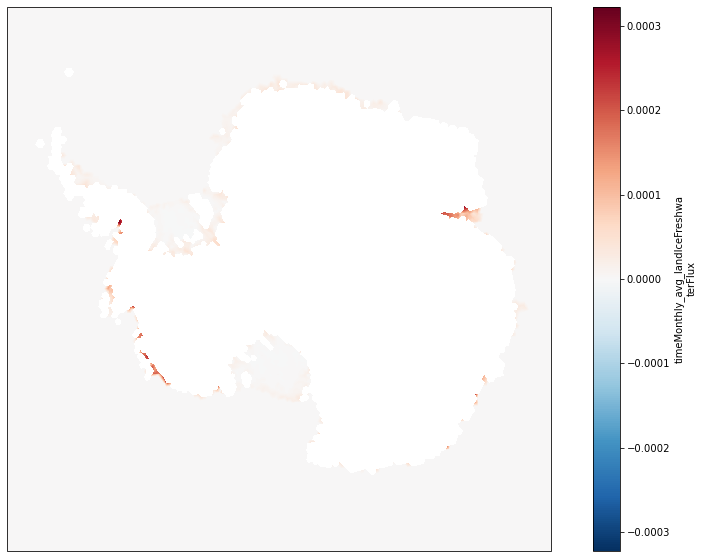

In [5]:
# Presents a sample plot of the entire ice sheet with the flux data at any time stamp

# Time stamp
ts = 1200

plt.figure(figsize=(15,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.gridlines()
# ax.coastlines(resolution='10m',linewidth=0.75)
# flux[ts].plot.contourf(ax=ax,levels=30)
flux[ts].plot()
# flux.mean('time').plot()
# icems.boundary.loc[[basin]].plot(ax=ax,color='blue',linewidth=0.25)

In [6]:
# Read geoJSON region feature file as POLYGON (GeoDataFrame)
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

In [7]:
# convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})
crs = ccrs.SouthPolarStereo()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [8]:
#Masked data
data.rio.write_crs("epsg:3031",inplace=True)

<xarray.Dataset>
Dimensions:                                (y: 601, x: 601, time: 1800)
Coordinates:
    lat                                    (y, x) float64 ...
    lon                                    (y, x) float64 ...
  * time                                   (time) datetime64[ns] 2001-01-31 ....
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    spatial_ref                            int64 0
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (time, y, x) float64 0.0 0.0 ... 0.0
    timeMonthly_avg_ssh                    (time, y, x) float64 ...
Attributes:
    history:   Wed Oct 27 15:35:43 2021: ncrcat RegriddedFluxSSH.0001-01-01.n...
    meshName:  6000.0x6000.0km_10.0km_Antarctic_stereo
    NCO:       netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, ...

In [47]:
## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites

basin = 34
basinName = icems.name.values[basin]

<GeoAxesSubplot:>

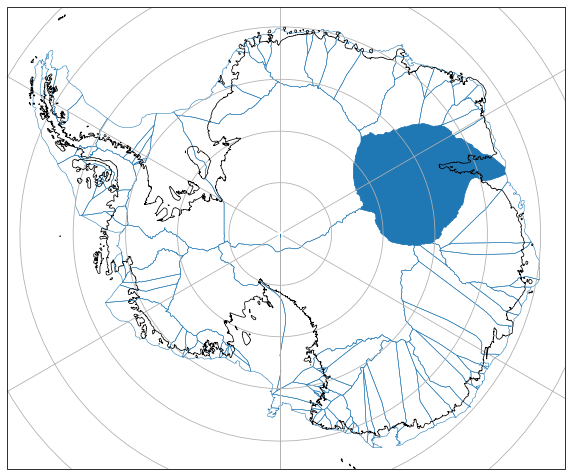

In [48]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[34:133].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax)

In [49]:
# Mask data to chosen basin
#  34 : Amery
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [50]:
flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

# lmax = np.max(flx)
# lmin = np.min(flx)

In [86]:
flx_series = flx.sum(['y','x'])

<GeoAxesSubplot:title={'center':'time = 2017-09-30, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

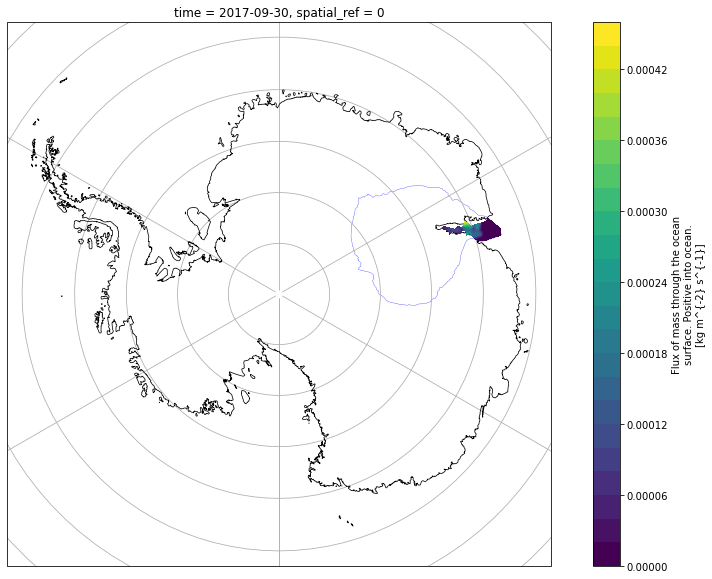

In [51]:
# Presents a sample plot of the ice shelf under question with the flux data at any time stamp

# Time stamp
ts = 200

plt.figure(figsize=(15,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
ax.coastlines(resolution='10m', zorder=3,linewidth=0.75)
# flx[10].plot.contourf(ax=ax,levels=np.linspace(lmin,lmax,30))
flx[ts].plot.contourf(ax=ax,levels=30,zorder=6)
# flx[ts].plot()
icems.boundary.loc[[basin]].plot(ax=ax,color='blue',linewidth=0.25)

In [52]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [53]:
flx_detrended = detrend_dim(flx, 'time', 1)

In [54]:
# Integrate flux across basin for time series
flx_detrended_series = flx_detrended.sum(['y','x'], skipna=True)

Text(0.5, 1.0, 'Raw Detrended Flux')

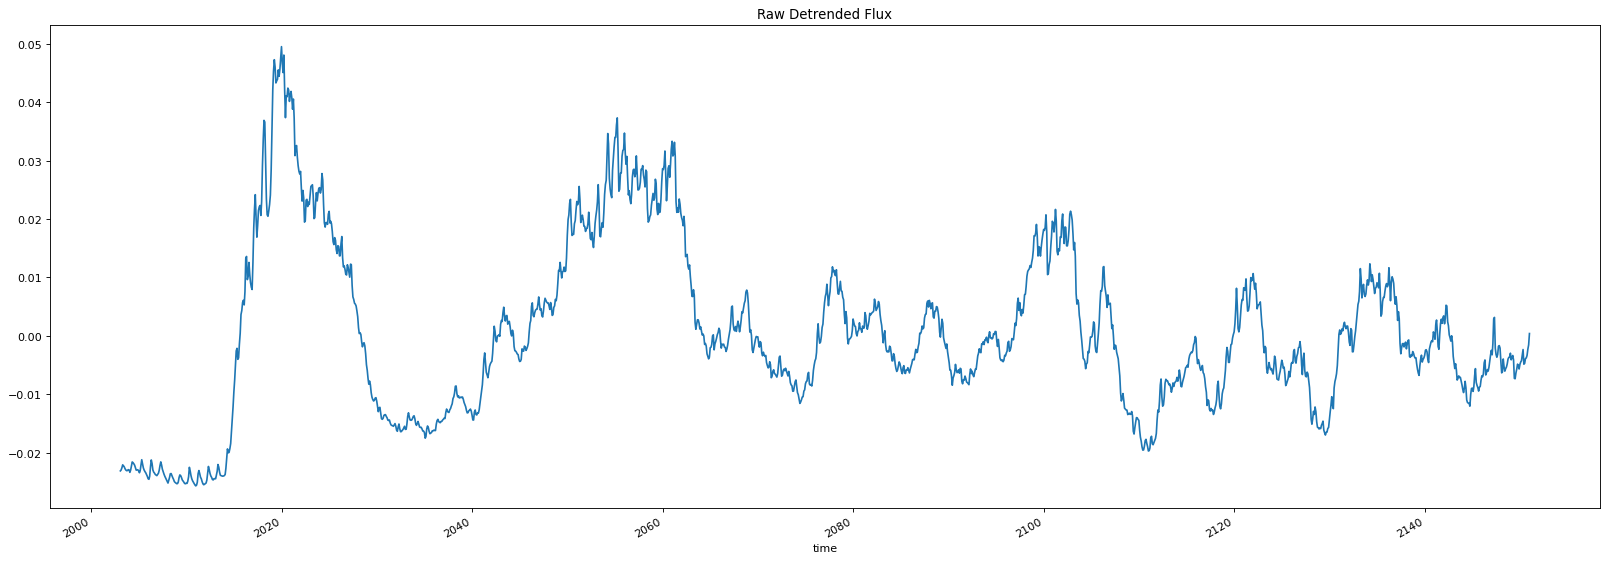

In [55]:
# change this to remove first few datapoints
tstart = 24

plt.figure(figsize=(25, 8), dpi=80)
flx_detrended_series[tstart:].plot()
plt.title('Raw Detrended Flux')

In [56]:
# Deseasonalize with monthly means
flx_monthly_means = flx_detrended.groupby("time.month").mean("time")
flx_deseasonalized = flx_detrended.groupby("time.month") - flx_monthly_means
flx_deseasonalized_series = flx_deseasonalized.sum(['y','x'], skipna=True)

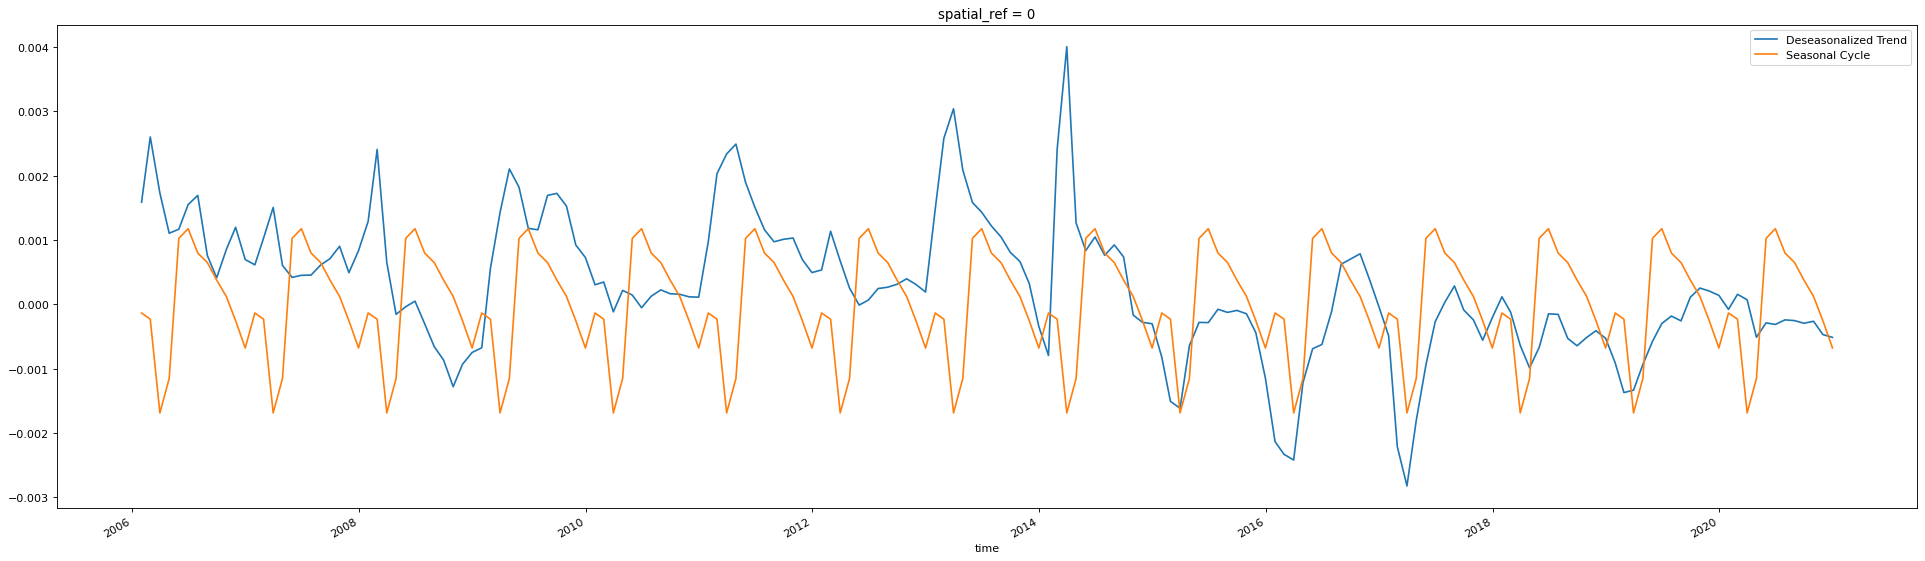

In [62]:
plt.figure(figsize=(30, 8), dpi=80)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
fl_deseasonalized_series[60:240].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[60:240].plot(label = 'Seasonal Cycle')
plt.legend()

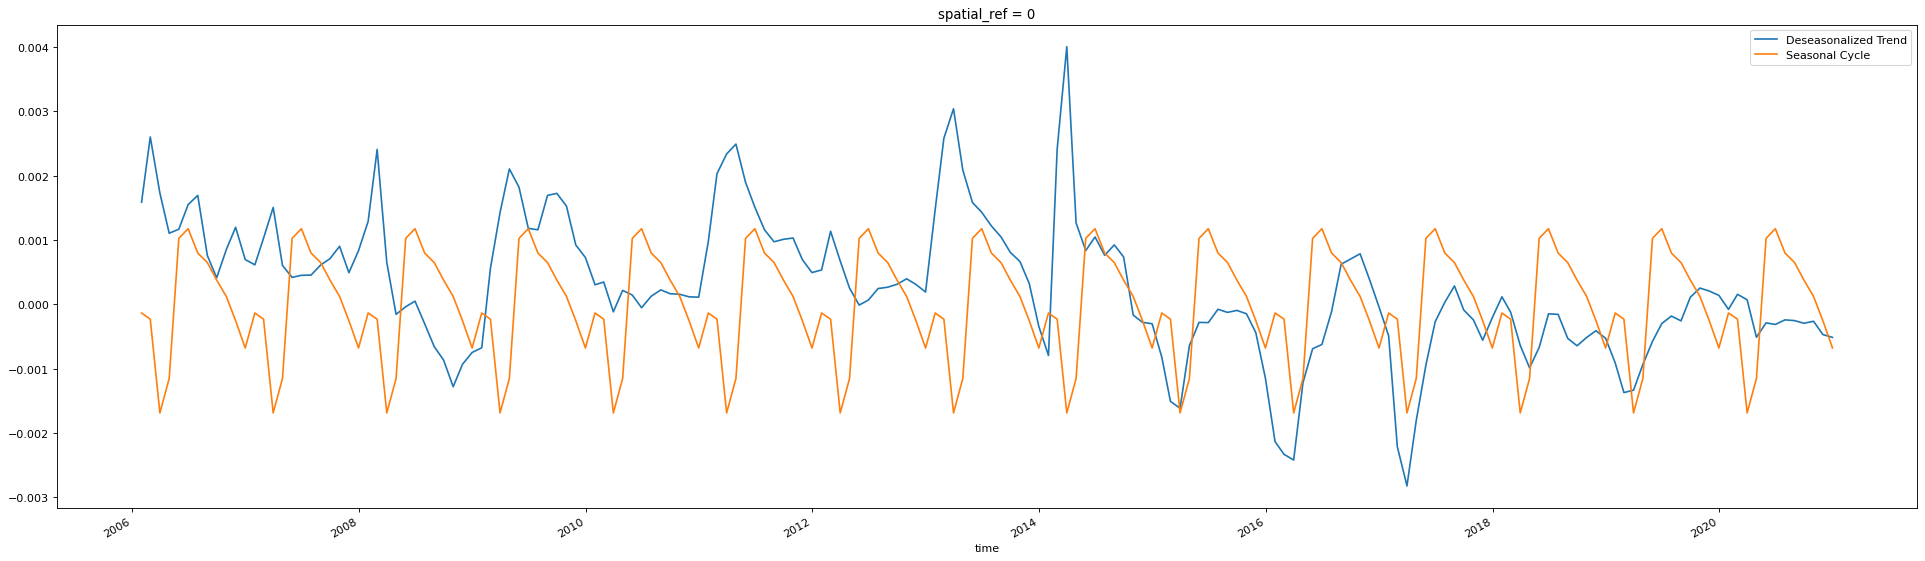

In [139]:
## TESTING ALTERNATES

# Deseasonalize with monthly means
flx_monthly_means = flx_detrended.groupby("time.month").mean("time")
flx_deseasonalized = flx_detrended.groupby("time.month") - flx_monthly_means
flx_deseasonalized_series = flx_deseasonalized.sum(['y','x'], skipna=True)

plt.figure(figsize=(30, 8), dpi=80)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
fl_deseasonalized_series[60:240].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[60:240].plot(label = 'Seasonal Cycle')
plt.legend()

In [149]:
flx_matr = flx_detrended.groupby("time.month")[2]
flx_matr


<xarray.DataArray (time: 150, y: 601, x: 601)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
  * x            (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
  * time         (time) datetime64[ns] 2001-02-28 2002-02-28 ... 2150-02-28
    spatial_ref  int64 0

Text(0.5, 1.0, 'ACF: Amery, Monthly Means')

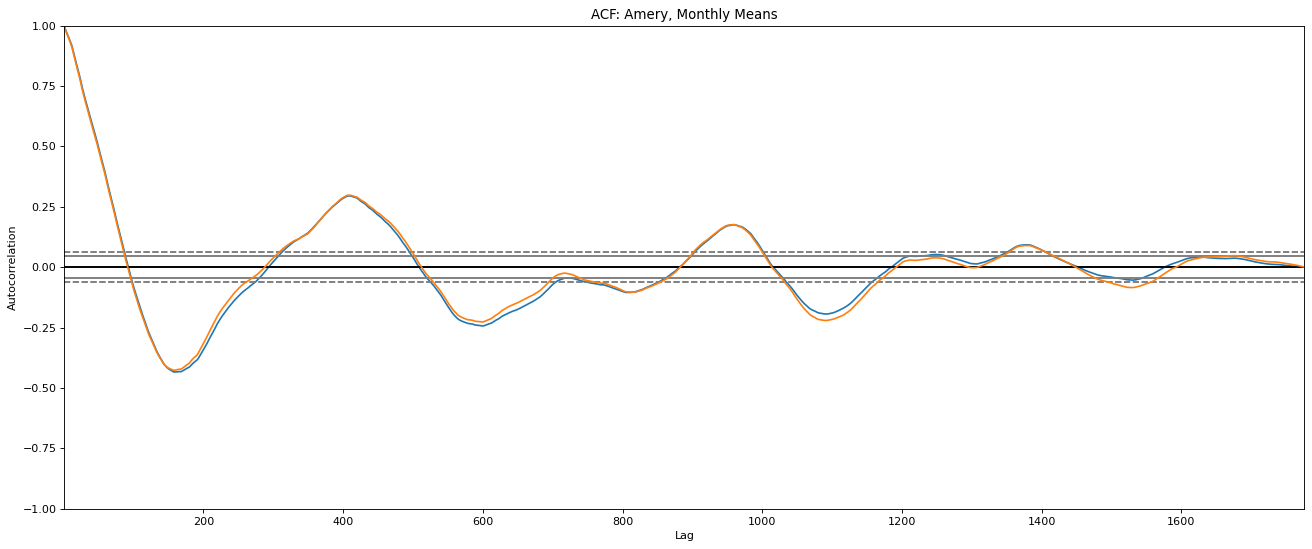

In [63]:
# plot autocorrelation
plt.figure(figsize=(20, 8), dpi=80)

fl = flx_deseasonalized_series[24:]
plt.clf()
fl_fourier = np.fft.rfft(fl)

# random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)

fl_fourier_new = fl_fourier*random_phases

new_fl = np.fft.irfft(fl_fourier_new)

pd.plotting.autocorrelation_plot(fl)
pd.plotting.autocorrelation_plot(new_fl)
plt.ylabel('Autocorrelation')
plt.title('ACF: {}, Monthly Means'.format(basinName))
#plt.savefig('{}_flux_ACF_dedrafted.png'.format(basinName))

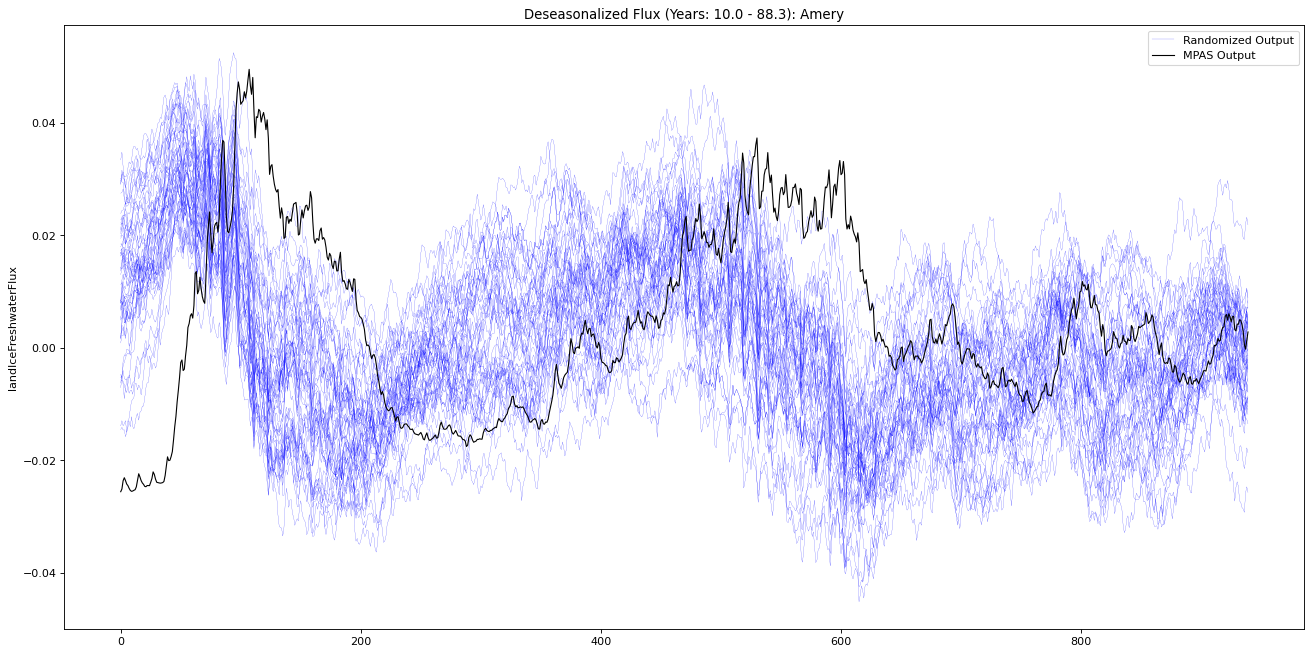

In [80]:
# plot autocorrelation
plt.figure(figsize=(20, 10), dpi=80)

spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 1000

for i in range(n_realizations):    
    fl = flx_detrended_series[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[5,t1:tf],'b', linewidth=0.15, label='Randomized Output')
plt.plot(fl[t1:tf],'k', linewidth=1, label='MPAS Output')
plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

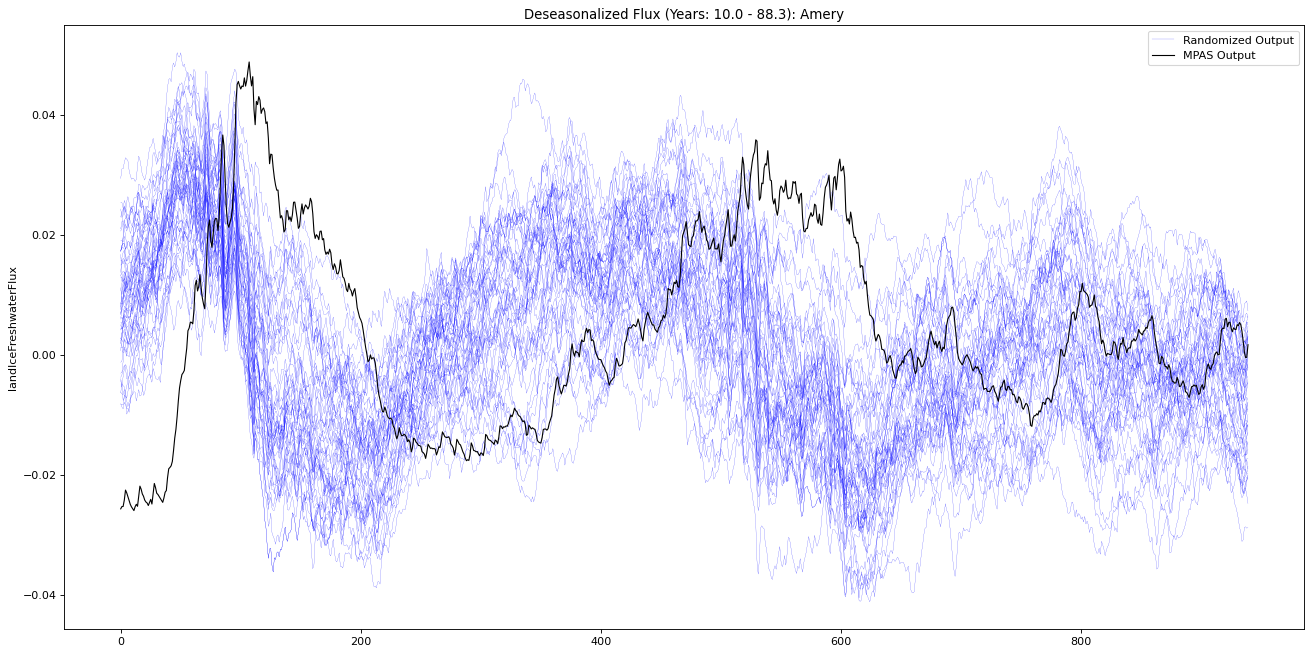

In [88]:
# plot autocorrelation
plt.figure(figsize=(20, 10), dpi=80)

spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 1000

for i in range(n_realizations):    
    fl = flx_deseasonalized_series[spinuptime:]
    # fl = flx_series[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[5,t1:tf],'b', linewidth=0.15, label='Randomized Output')
plt.plot(fl[t1:tf],'k', linewidth=1, label='MPAS Output')
plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

## Data Exploration using STL (for comparison)

In [92]:
from statsmodels.tsa.seasonal import STL

In [102]:
flx_STL = STL(flx_detrended_series, period=11).fit()

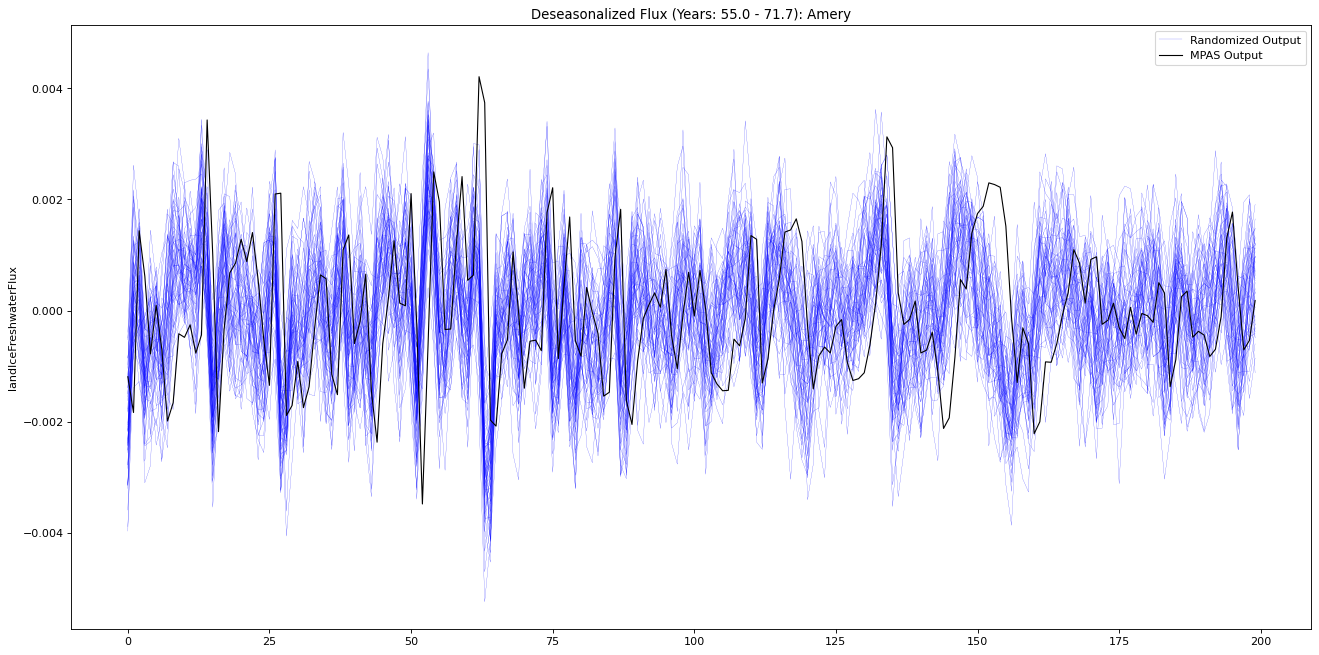

In [138]:
# plot autocorrelation
plt.figure(figsize=(20, 10), dpi=80)

spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

# Time limits for plotting
t1 = 600
tf = 800

for i in range(n_realizations):    
    fl = flx_STL.resid[spinuptime:]
    # fl = flx_series[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[5,t1:tf],'b', linewidth=0.15, label='Randomized Output')
plt.plot(fl[t1:tf],'k', linewidth=1, label='MPAS Output')
plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

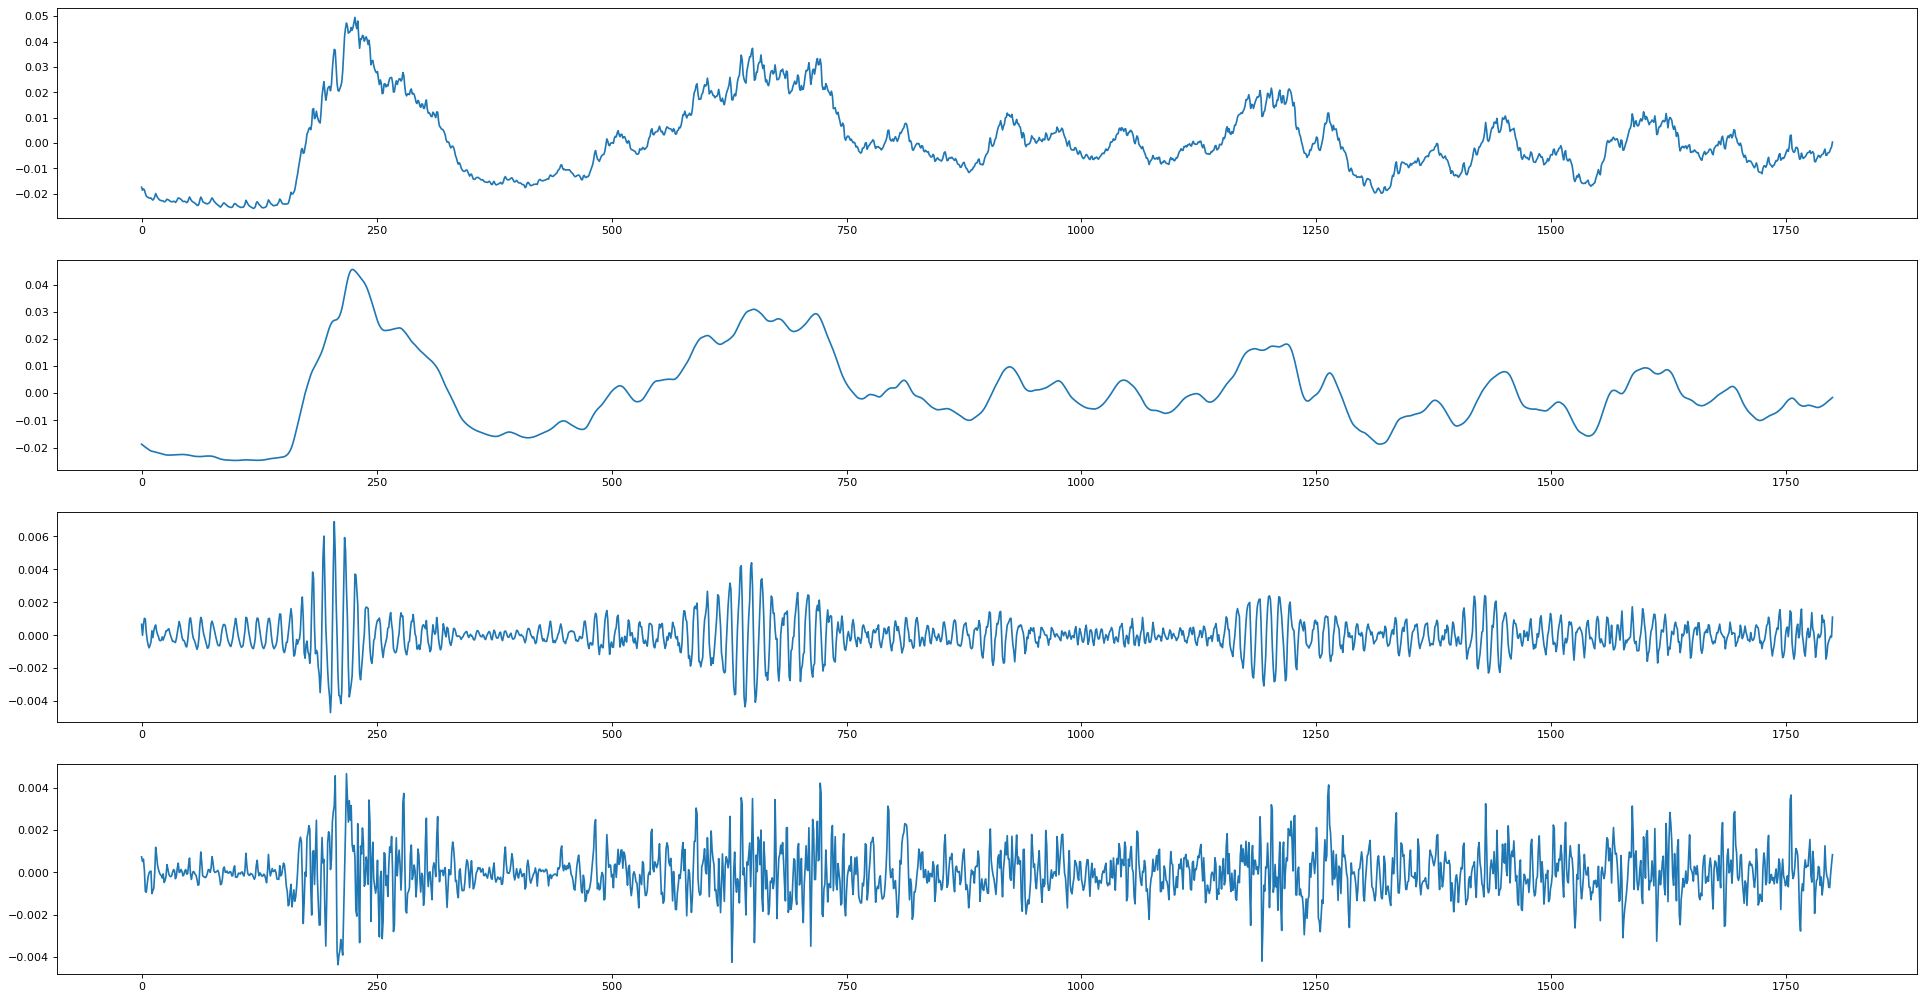

In [105]:
plt.subplots(figsize=(30, 16), dpi=80)
plt.subplot(411)
plt.plot(flx_STL.observed)

plt.subplot(412)
plt.plot(flx_STL.trend)

plt.subplot(413)
plt.plot(flx_STL.seasonal)

plt.subplot(414)
plt.plot(flx_STL.resid)

In [106]:
flx_deSTL = flx_detrended_series - flx_STL.seasonal

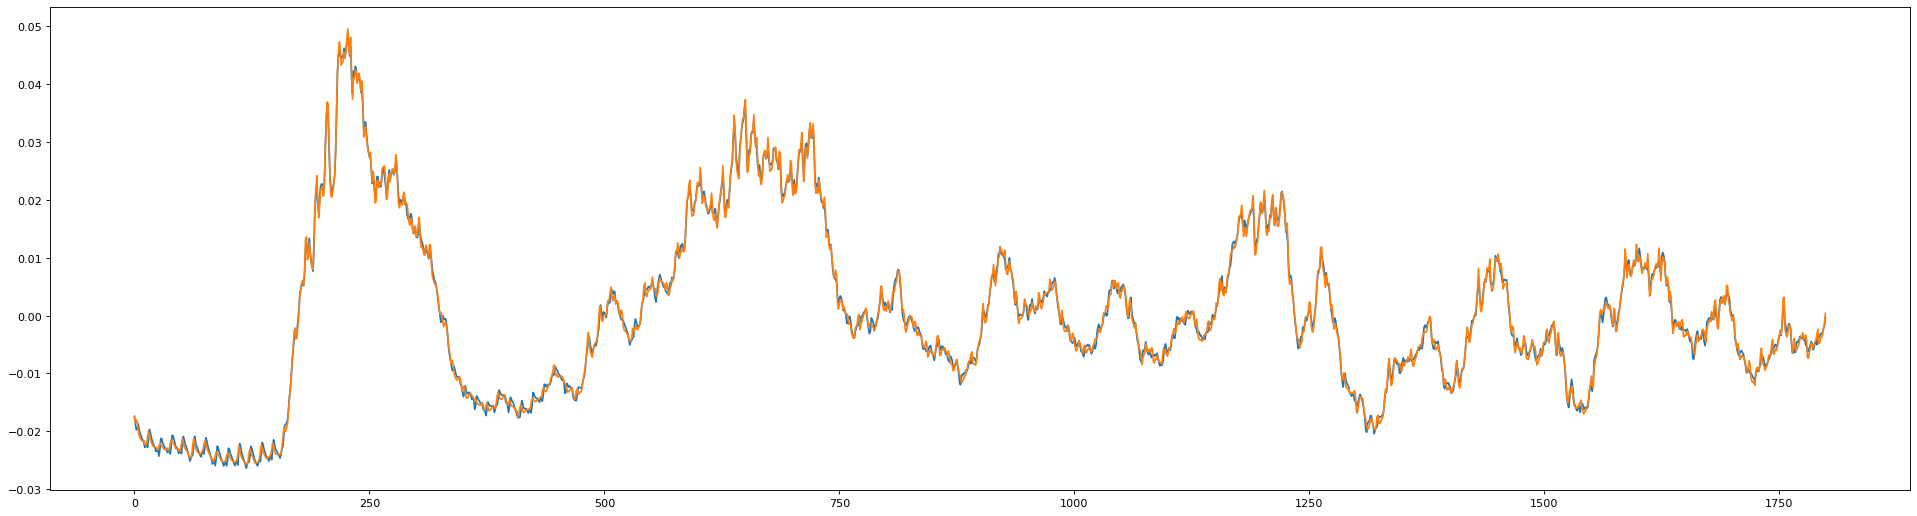

In [121]:
plt.figure(figsize=(30, 8), dpi=80)
#plt.plot(flx_deSTL)
plt.plot(flx_deseasonalized_series)
#plt.plot(flx_STL.resid)
plt.plot(flx_STL.trend+flx_STL.seasonal+flx_STL.resid)

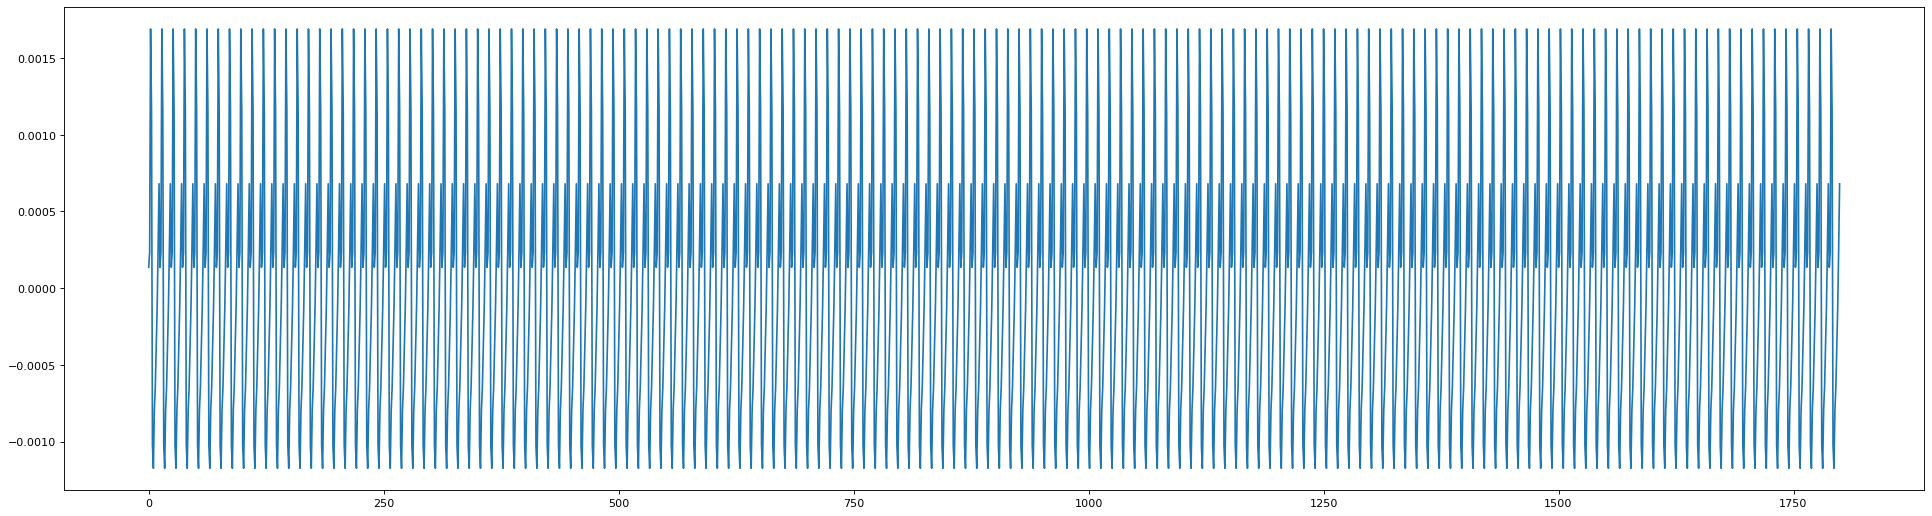

In [123]:
plt.figure(figsize=(30, 8), dpi=80)
plt.plot(flx_STL.trend+flx_STL.seasonal+flx_STL.resid-flx_deseasonalized_series)

In [124]:
from statsmodels.graphics.tsaplots import plot_acf

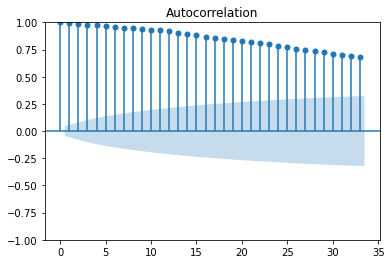

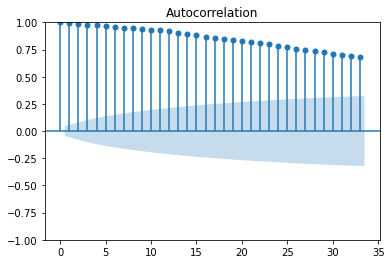

In [131]:
plot_acf(flx_detrended_series)